# Overfitting Test

aIn this notebook, we will be making predictions on the full sample (includes training, validation, testing data).
<br>
Obtaining a new rejection value at 90% signal efficiency and comparing it to value found from prediction on testing data.

In [1]:
# Import required packages
import pickle
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib as mpl  

In [2]:
# Setting up parameters for plot
mpl.rcParams['figure.figsize'] = [14.0, 10.0]
mpl.rcParams['font.size']=15

### Import data

In [3]:
ele_data = np.loadtxt('cut_ele_data_flat.txt', delimiter = '	')
jet_data = np.loadtxt('cut_jet_data_flat.txt', delimiter = '	')

ele_data_cell = []                          # array for electron cell information

for i in range (len(ele_data)):
    ele_data_cell.append(ele_data[i][12:])
    
jet_data_cell = []                          # array for jet cell information

for i in range (len(jet_data)):
    jet_data_cell.append(jet_data[i][12:])
    

sample = np.append(ele_data_cell, jet_data_cell, axis = 0)
print("Shape of testing sample", np.shape(sample))

Shape of testing sample (10595, 51)


In [4]:
def convert2D(data):
    '''
    Function to convert data array into 2D picture
    
    Input: 
    data in shape (51,)
    
    Output: 
    data in picture shaped (3,17)
    '''
    array = []
    for i in range (len(data)):
        a = np.reshape(data[i], [3, 17])
        array.append(a)
    return np.array(array)

In [5]:
def mnorm(data):
    '''
    Function for normalise image data to have a range of pixel intensity of [0,1]
    Input:
    data to be normalised
    
    Output:
    normalised data
    '''
    normdata=[]
    for i in range (len(data)):
        normdata.append(data[i]/np.max(data[i]))
    return np.asarray(normdata)

In [6]:
def snorm(data):
    '''
    Function for normalising image data to have a range of pixel intensity of [0,1]
    Input:
    data = data to be normalised
    Output:
    Normalised data
    '''
    normdata=[]
    for i in range (len(data)):
        normdata.append(data[i]/np.sum(data[i]))
    return np.asarray(normdata)

In [7]:
def testing(model_name, data, normalised, shape, lmt):
    '''
    Function to test each model with their data processed accordingly
    
    Input:
    model_name = Name of Model used
    data = test data
    normalised = 0(original) / 1(normalised(max)) / 2(normalised(sum))
    shape = 2(CNN) / 1(all other models)
    lmt = no. of electron events in data
    Output:
    Performance of each model
    '''
    
    ######### Data Processing #########
    # For model trained with original data
    if normalised == 0:
        filename = str(model_name) + 'original.pickle'
        print("Using", model_name, "original")
        
        # For CNN
        if shape == 2:
            x = convert2D(data)
        
        # For other models
        elif shape == 1:
            x = data

    # For model trained with norm(max) data
    elif normalised == 1:
        filename = str(model_name) + 'normalised(max).pickle'
        print("Using", model_name, "normalised(max)")
        
        # For CNN
        if shape == 2:
            x = mnorm(data)
            x = convert2D(x)
            
        # For other models
        elif shape == 1:
            x = mnorm(data)
    
    # For model trained with norm(sum)
    elif normalised == 2:
        filename = str(model_name) + 'normalised(sum).pickle'
        print("Using", model_name, "normalised(sum)")
        
        # For CNN
        if shape == 2:
            x = snorm(data)
            x = convert2D(x)
            
        # For other models
        elif shape == 1:
            x = snorm(data)
    
    # Load saved models
    model = pickle.load(open(filename,'rb'))
    
    ######### Making Predictions ##########
    
    # For CNN
    if model_name == "CNN":
        prob = model.predict(x)
        
    # For other models
    else:
        prob = model.predict_proba(x)[:,1]
    
    # Label testing data
    ele_label = np.ones(lmt)
    jet_label = np.zeros(10595-(lmt))
    
    true_label = np.append(ele_label, jet_label, axis = 0)   
    
    # Obtaining ROC score
    roc_auc = roc_auc_score(true_label, prob)
    print("ROC Score =", roc_auc)
    
    # Obtaining ROC curve for models
    fpr, tpr, thresholds = roc_curve(true_label, prob) 
    value = np.interp(0.9, tpr, fpr)                                # obtain fpr for 90% tpr on ROC curve
    print("At 90% signal efficiency we have a false positive rate of {0:.4f}". format(value))
    print()


    # Plot
    plt.figure(1)
    plt.title("ROC")                                     # plot title       
    
    # Set up plot label
    if normalised == 0:
        data_name = 'original'
    elif normalised == 1:
        data_name = 'normalised(max)'
    elif normalised == 2:
        data_name = 'normalised(sum)'
        
    plt.plot(fpr, tpr, label=model_name+data_name)       # plot
    plt.legend(loc='best')                               # show legend
    plt.xticks(np.arange(0,1.1,0.1));                    # set x axis ticks
    plt.yticks(np.arange(0,1.1,0.1));                    # set y axis ticks   
    plt.grid(True)                                       # show grid

Using CNN original
332/332 [==============================] - 8s 8ms/step
ROC Score = 0.9214779380024414
At 90% signal efficiency we have a false positive rate of 0.1771

Using CNN normalised(max)
332/332 [==============================] - 4s 12ms/step
ROC Score = 0.9330364062816139
At 90% signal efficiency we have a false positive rate of 0.1639

Using CNN normalised(sum)
332/332 [==============================] - 2s 7ms/step
ROC Score = 0.9264327482712791
At 90% signal efficiency we have a false positive rate of 0.1823

Using NearestNeighbour original
ROC Score = 0.8981743515376739
At 90% signal efficiency we have a false positive rate of 0.2771

Using NearestNeighbour normalised(max)
ROC Score = 0.916628603816652
At 90% signal efficiency we have a false positive rate of 0.2140

Using NearestNeighbour normalised(sum)
ROC Score = 0.9185824591706003
At 90% signal efficiency we have a false positive rate of 0.2063

Using DecisionTree original
ROC Score = 0.9001398235142821
At 90% signal

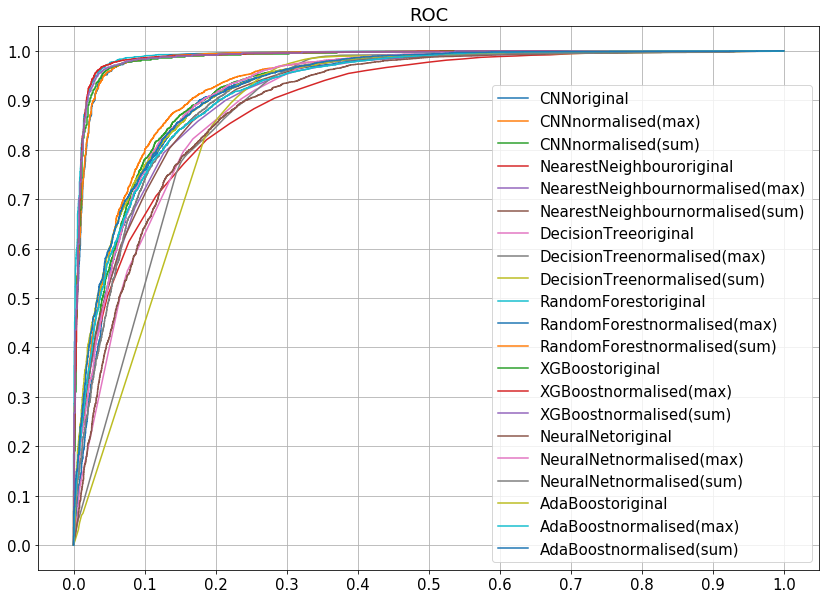

In [8]:
testing('CNN', sample, 0, 2, 5281)
testing('CNN', sample, 1, 2, 5281)
testing('CNN', sample, 2, 2, 5281)


testing('NearestNeighbour', sample, 0, 1, 5281)
testing('NearestNeighbour', sample, 1, 1, 5281)
testing('NearestNeighbour', sample, 2, 1, 5281)


testing('DecisionTree', sample, 0, 1, 5281)
testing('DecisionTree', sample, 1, 1, 5281)
testing('DecisionTree', sample, 2, 1, 5281)

testing('RandomForest', sample, 0, 1, 5281)
testing('RandomForest', sample, 1, 1, 5281)
testing('RandomForest', sample, 2, 1, 5281)


testing('XGBoost', sample, 0, 1, 5281)
testing('XGBoost', sample, 1, 1, 5281)
testing('XGBoost', sample, 2, 1, 5281)


testing('NeuralNet', sample, 0, 1, 5281)
testing('NeuralNet', sample, 1, 1, 5281)
testing('NeuralNet', sample, 2, 1, 5281)


testing('AdaBoost', sample, 0, 1, 5281)
testing('AdaBoost', sample, 1, 1, 5281)
testing('AdaBoost', sample, 2, 1, 5281)

